Implicit Rank-Minimizing Autoencoder
======
Li Jing, Jure Zbontar and Yann LeCun

Paper Link - https://arxiv.org/abs/2010.00679 

Brief Abstract : \
The authors show that the rank of the covariance matrix of the latent space is implicitly minimized by inserting a few extra linear layers at the output of the encoder. They rely on the fact that gradient descent learning in multi-layer linear networks leads to low-rank solutions. They call the proposed method as IRMAE and show its validity on several tasks by inspecting the rank of the covariance matrix of the latent space evaluated on the latent representations of the test set.

Accompanying Blog post link :- https://dibyadas.github.io/posts/9th

In [ ]:
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

Parameter Settings
-------------------


In [ ]:
latent_dims = 128
num_epochs = 50
batch_size = 128
capacity = 24
learning_rate = 1e-3
use_gpu = True

Results on MNIST
-------------------

In the paper, they have used a latent dimension of 128 and number of linear layers at the end of encoder as 8

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Autoencoder Definition
-----------------------



In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.conv3 = nn.Conv2d(in_channels=c*2, out_channels=c, kernel_size=1) # out: c x 7 x 7
        self.fc = nn.Linear(in_features=c*7*7, out_features=latent_dims)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x = self.fc(x)
        
        return x
        

The following module is the key difference between vanilla autoencoders and IRMAE. Apart from the showing the effect of linear layers, I have also added methods for ablation study as mentioned in the paper.

* **Linear** : $l$ number of linear layers after the output of the encoder.
* **Weight Share** : Same as Linear except all of the linear layers share the same weight. Equivalent to evaluating $x$ on the same linear layer $l$ times. Using this results in a weakened regularization effect as compared to Linear.
* **Fixed** : Same as Linear but all of the layers are fixed weights. This will show that the results are due to learning dynamics instead of the architechture.
* **Non Linear** : $l$ linear layers but with ReLU activations in-between them which is equivalent to a deeper encoder. This will show that the results are not due to deeper architecture.


In [ ]:
class LNN(nn.Module):
    def __init__(self, num_of_linear_layers, type):
        self.num_of_linear_layers = num_of_linear_layers
        super(LNN, self).__init__()

        if type == "linear":
            self.linear_layer = nn.ModuleList([nn.Linear(in_features=latent_dims, out_features=latent_dims) for _ in range(num_of_linear_layers)])
            self.forward = self.forward_linear

        if type == "weight_share":
            self.linear_layer = nn.Linear(in_features=latent_dims, out_features=latent_dims)
            self.forward = self.forward_weight_share

        if type == "fixed":
            self.linear_layer = nn.ModuleList([nn.Linear(in_features=latent_dims, out_features=latent_dims) for _ in range(num_of_linear_layers)])
            for layer in self.linear_layer:
                for param in layer.parameters():
                    param.requires_grad = False
            self.forward = self.forward_fixed

        if type == "nonlinear":
            self.linear_layer = nn.ModuleList([nn.Linear(in_features=latent_dims, out_features=latent_dims) for _ in range(num_of_linear_layers)])
            self.forward = self.forward_nonlinear
        
    def forward_linear(self, x):
        for layer in self.linear_layer:
            x = layer(x)
        return x

    def forward_weight_share(self, x):
        for _ in range(self.num_of_linear_layers):
            x = self.linear_layer(x)
        return x
    
    def forward_fixed(self, x):
        for layer in self.linear_layer:
            x = layer(x)
        return x
    
    def forward_nonlinear(self, x):
        for layer in self.linear_layer:
            x = F.relu(layer(x))
        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*7*7)
        self.conv3 = nn.ConvTranspose2d(in_channels=c, out_channels=c*2, kernel_size=1)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
        
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv2(x))
        x = torch.tanh(self.conv1(x)) # last layer before output is tanh, since the images are normalized and 0-centered
        return x

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.lnn = LNN(*args, **kwargs)
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        min_rank_latent = self.lnn(latent)
        x_recon = self.decoder(min_rank_latent)
        return x_recon

In [ ]:
autoencoder = Autoencoder(8,'linear')

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
autoencoder = autoencoder.to(device)

num_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 474561


In [ ]:
autoencoder(torch.rand(128,1,28,28).cuda()).shape

torch.Size([128, 1, 28, 28])

Train Autoencoder
--------

In [ ]:
def train(layers=0, type="linear", model=None, lr=1e-3, num_epochs=50):
    print(lr)
    if model == None:
        autoencoder = Autoencoder(layers, type)
    else:
        autoencoder = model
    
    device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
    autoencoder = autoencoder.to(device)
    num_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
    print('Number of parameters: %d' % num_params)
    optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate)#, momentum=0.5)

    # set to training mode
    autoencoder.train()

    train_loss_avg = []

    print('Training ...')
    for epoch in range(num_epochs):
        train_loss_avg.append(0)
        num_batches = 0
        
        for image_batch, _ in train_dataloader:
            # print(image_batch.shape)
            image_batch = image_batch.to(device)
            
            # autoencoder reconstruction
            image_batch_recon = autoencoder(image_batch)
            
            # reconstruction error
            loss = F.mse_loss(image_batch_recon, image_batch)
            
            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            
            # one step of the optmizer (using the gradients from backpropagation)
            optimizer.step()
            
            train_loss_avg[-1] += loss.item()
            num_batches += 1
            
        train_loss_avg[-1] /= num_batches
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
    return autoencoder, train_loss_avg

In [ ]:
capacity = 24

In [ ]:
standard_ae, standard_ae_train_loss_avg = train(0, 'linear', num_epochs=50)

0.001
Number of parameters: 342465
Training ...
Epoch [1 / 50] average reconstruction error: 0.110448
Epoch [2 / 50] average reconstruction error: 0.019808
Epoch [3 / 50] average reconstruction error: 0.013930
Epoch [4 / 50] average reconstruction error: 0.011397
Epoch [5 / 50] average reconstruction error: 0.009940
Epoch [6 / 50] average reconstruction error: 0.008891
Epoch [7 / 50] average reconstruction error: 0.008137
Epoch [8 / 50] average reconstruction error: 0.007538
Epoch [9 / 50] average reconstruction error: 0.007063
Epoch [10 / 50] average reconstruction error: 0.006647
Epoch [11 / 50] average reconstruction error: 0.006306
Epoch [12 / 50] average reconstruction error: 0.005980
Epoch [13 / 50] average reconstruction error: 0.005718
Epoch [14 / 50] average reconstruction error: 0.005482
Epoch [15 / 50] average reconstruction error: 0.005247
Epoch [16 / 50] average reconstruction error: 0.005058
Epoch [17 / 50] average reconstruction error: 0.004863
Epoch [18 / 50] average re

In [ ]:
standard_ae

Autoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(24, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1))
    (fc): Linear(in_features=1176, out_features=128, bias=True)
  )
  (lnn): LNN(
    (linear_layer): ModuleList()
  )
  (decoder): Decoder(
    (fc): Linear(in_features=128, out_features=1176, bias=True)
    (conv3): ConvTranspose2d(24, 48, kernel_size=(1, 1), stride=(1, 1))
    (conv2): ConvTranspose2d(48, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv1): ConvTranspose2d(24, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

In [ ]:
linear_irmae, linear_train_loss_avg = train(layers=8, type='linear',lr=1e-2,num_epochs=50)
# linear_irmae, linear_train_loss_avg = train(model=linear_irmae, lr=4*1e-3, num_epochs=50)

0.01
Number of parameters: 474561
Training ...
Epoch [1 / 50] average reconstruction error: 0.246715
Epoch [2 / 50] average reconstruction error: 0.159109
Epoch [3 / 50] average reconstruction error: 0.124943
Epoch [4 / 50] average reconstruction error: 0.109814
Epoch [5 / 50] average reconstruction error: 0.098878
Epoch [6 / 50] average reconstruction error: 0.091680
Epoch [7 / 50] average reconstruction error: 0.086213
Epoch [8 / 50] average reconstruction error: 0.080563
Epoch [9 / 50] average reconstruction error: 0.076581
Epoch [10 / 50] average reconstruction error: 0.072397
Epoch [11 / 50] average reconstruction error: 0.068905
Epoch [12 / 50] average reconstruction error: 0.066495
Epoch [13 / 50] average reconstruction error: 0.063993
Epoch [14 / 50] average reconstruction error: 0.062099
Epoch [15 / 50] average reconstruction error: 0.060293
Epoch [16 / 50] average reconstruction error: 0.058733
Epoch [17 / 50] average reconstruction error: 0.056459
Epoch [18 / 50] average rec

In [ ]:
weight_share_irmae, weight_share_train_loss_avg = train(8, 'weight_share', num_epochs=50)

0.001
Number of parameters: 358977
Training ...
Epoch [1 / 50] average reconstruction error: 0.233443
Epoch [2 / 50] average reconstruction error: 0.153781
Epoch [3 / 50] average reconstruction error: 0.131630
Epoch [4 / 50] average reconstruction error: 0.118210
Epoch [5 / 50] average reconstruction error: 0.113623
Epoch [6 / 50] average reconstruction error: 0.100617
Epoch [7 / 50] average reconstruction error: 0.087459
Epoch [8 / 50] average reconstruction error: 0.072516
Epoch [9 / 50] average reconstruction error: 0.068098
Epoch [10 / 50] average reconstruction error: 0.065520
Epoch [11 / 50] average reconstruction error: 0.061214
Epoch [12 / 50] average reconstruction error: 0.057911
Epoch [13 / 50] average reconstruction error: 0.050897
Epoch [14 / 50] average reconstruction error: 0.047932
Epoch [15 / 50] average reconstruction error: 0.045667
Epoch [16 / 50] average reconstruction error: 0.042670
Epoch [17 / 50] average reconstruction error: 0.040211
Epoch [18 / 50] average re

In [ ]:
fixed_irmae, fixed_train_loss_avg = train(8, 'fixed', num_epochs=50)

0.001
Number of parameters: 342465
Training ...
Epoch [1 / 50] average reconstruction error: 0.177987
Epoch [2 / 50] average reconstruction error: 0.055486
Epoch [3 / 50] average reconstruction error: 0.041518
Epoch [4 / 50] average reconstruction error: 0.033745
Epoch [5 / 50] average reconstruction error: 0.029578
Epoch [6 / 50] average reconstruction error: 0.026916
Epoch [7 / 50] average reconstruction error: 0.024965
Epoch [8 / 50] average reconstruction error: 0.023365
Epoch [9 / 50] average reconstruction error: 0.021985
Epoch [10 / 50] average reconstruction error: 0.020711
Epoch [11 / 50] average reconstruction error: 0.019679
Epoch [12 / 50] average reconstruction error: 0.018800
Epoch [13 / 50] average reconstruction error: 0.018048
Epoch [14 / 50] average reconstruction error: 0.017458
Epoch [15 / 50] average reconstruction error: 0.016885
Epoch [16 / 50] average reconstruction error: 0.016415
Epoch [17 / 50] average reconstruction error: 0.015937
Epoch [18 / 50] average re

In [ ]:
non_linear_irmae, non_linear_train_loss_avg = train(8, 'nonlinear', num_epochs=50)

0.001
Number of parameters: 474561
Training ...
Epoch [1 / 50] average reconstruction error: 0.256205
Epoch [2 / 50] average reconstruction error: 0.134872
Epoch [3 / 50] average reconstruction error: 0.107586
Epoch [4 / 50] average reconstruction error: 0.094427
Epoch [5 / 50] average reconstruction error: 0.084518
Epoch [6 / 50] average reconstruction error: 0.077581
Epoch [7 / 50] average reconstruction error: 0.073627
Epoch [8 / 50] average reconstruction error: 0.070722
Epoch [9 / 50] average reconstruction error: 0.067436
Epoch [10 / 50] average reconstruction error: 0.064352
Epoch [11 / 50] average reconstruction error: 0.061777
Epoch [12 / 50] average reconstruction error: 0.059331
Epoch [13 / 50] average reconstruction error: 0.056452
Epoch [14 / 50] average reconstruction error: 0.054408
Epoch [15 / 50] average reconstruction error: 0.051995
Epoch [16 / 50] average reconstruction error: 0.050461
Epoch [17 / 50] average reconstruction error: 0.048666
Epoch [18 / 50] average re

Plot Training Curve
--------------------

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

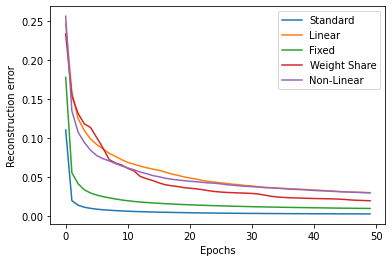

<Figure size 432x288 with 0 Axes>

In [ ]:

fig = plt.figure()
plt.plot(standard_ae_train_loss_avg, label="Standard")
plt.plot(linear_train_loss_avg, label="Linear")
plt.plot(fixed_train_loss_avg, label="Fixed")
plt.plot(weight_share_train_loss_avg, label="Weight Share")
plt.plot(non_linear_train_loss_avg, label="Non-Linear")
plt.legend(loc="upper right")
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()
plt.savefig("train_plot.png")

Evaluate on the Test Set
-------------------------

In [ ]:
def get_singular_values(trained_irmae):
    cov_latent = torch.zeros((latent_dims,latent_dims)).to(device)
    trained_irmae.eval()
    test_loss_avg, num_batches = 0, 0
    for image_batch, _ in test_dataloader:
        
        with torch.no_grad():

            image_batch = image_batch.to(device)

            # autoencoder reconstruction
            latent = trained_irmae.encoder(image_batch)
            min_rank_latent = trained_irmae.lnn(latent)
            cov_latent += min_rank_latent.T @ min_rank_latent
            image_batch_recon = trained_irmae(image_batch)

            # reconstruction error
            loss = F.mse_loss(image_batch_recon, image_batch)

            test_loss_avg += loss.item()
            num_batches += 1
        
    test_loss_avg /= num_batches
    print('average reconstruction error: %f' % (test_loss_avg))
    _,d,_ = torch.svd(cov_latent)
    return cov_latent, (d/d.max()).cpu()

In [ ]:
standard_cov, standard_ae_singular_values = get_singular_values(standard_ae)
linear_cov, linear_singular_values = get_singular_values(linear_irmae)
weight_share_cov, weight_share_singular_values = get_singular_values(weight_share_irmae)
fixed_cov, fixed_singular_values = get_singular_values(fixed_irmae)
non_linear_cov, non_linear_singular_values = get_singular_values(non_linear_irmae)

average reconstruction error: 0.002873
average reconstruction error: 0.030684
average reconstruction error: 0.020150
average reconstruction error: 0.009760
average reconstruction error: 0.031783


In [ ]:
torch.matrix_rank(weight_share_cov)

tensor(28, device='cuda:0')

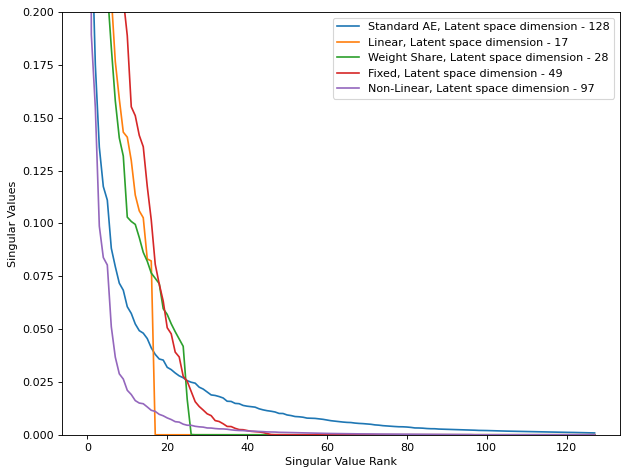

In [ ]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(9, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(standard_ae_singular_values, label=f'Standard AE, Latent space dimension - {torch.matrix_rank(standard_cov)}')
plt.plot(linear_singular_values, label=f'Linear, Latent space dimension - {torch.matrix_rank(linear_cov)}')
plt.plot(weight_share_singular_values, label=f'Weight Share, Latent space dimension - {torch.matrix_rank(weight_share_cov)}')
plt.plot(fixed_singular_values, label=f'Fixed, Latent space dimension - {torch.matrix_rank(fixed_cov)}')
plt.plot(non_linear_singular_values, label=f'Non-Linear, Latent space dimension - {torch.matrix_rank(non_linear_cov)}')
plt.ylabel('Singular Values')
plt.xlabel('Singular Value Rank')
plt.legend(loc="upper right")
plt.ylim(0,0.2)
plt.savefig("from_2_all_singular.png")

Visualize Reconstructions
--------------------------

In [ ]:
_,d,_ = torch.svd(cov_latent)

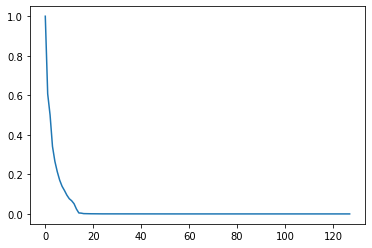

In [ ]:
plt.plot((d/d.max()).cpu())

In [ ]:
autoencoder = non_linear_irmae

Original images


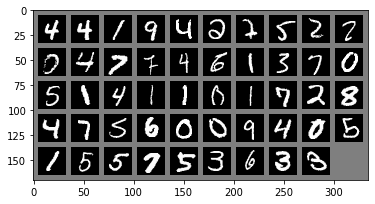

Autoencoder reconstruction:


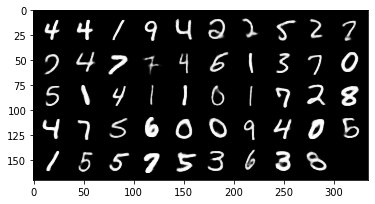

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

autoencoder.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():

        images = images.to(device)
        images = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(test_dataloader).next()

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the autoencoder
print('Autoencoder reconstruction:')
visualise_output(images, autoencoder)

Interpolate in Latent Space
----------------------------

In [ ]:
# autoencoder = standard_ae
# autoencoder = linear_irmae
# autoencoder = weight_share_irmae
# autoencoder = fixed_irmae
autoencoder = non_linear_irmae

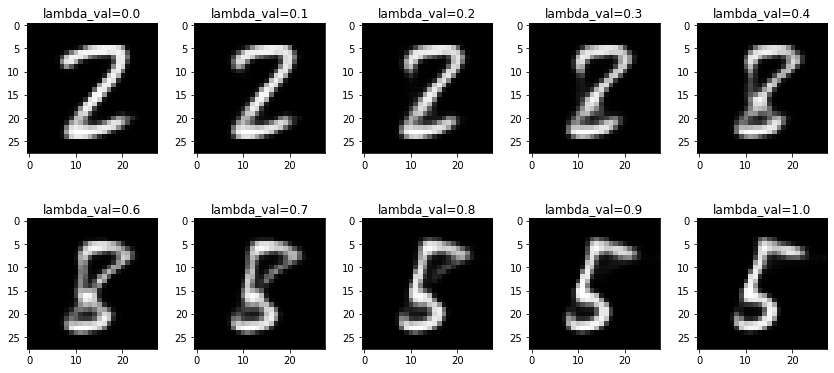

In [ ]:
autoencoder.eval()

def interpolation(lambda1, model, img1, img2):
    
    with torch.no_grad():

        # latent vector of first image
        img1 = img1.to(device)
        latent_1 = model.encoder(img1)
        latent_1 = model.lnn(latent_1)
        

        # latent vector of second image
        img2 = img2.to(device)
        latent_2 = model.encoder(img2)
        latent_2 = model.lnn(latent_2)

        # interpolation of the two latent vectors
        inter_latent = lambda1 * latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()
    
    return inter_image
    
# sort part of test set by digit
# digits = [[] for _ in range(10)]
# for img_batch, label_batch in test_dataloader:
#     for i in range(img_batch.size(0)):
#         digits[label_batch[i]].append(img_batch[i:i+1])
#     if sum(len(d) for d in digits) >= 1000:
#         break;

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()


for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), autoencoder, digits[5][0], digits[2][0])
  
    inter_image = to_img(inter_image)
    
    image = inter_image.numpy()
  
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))

plt.show() 

Notebook Credits to :- https://github.com/smartgeometry-ucl/dl4g/blob/master/autoencoder.ipynb
I built on top of their work to add linear neural network module

#### - Dibya Prakash Das